# 02 - Overfitting y Underfitting

## **Objetivos**

- Comprender qué es el **overfitting** (sobreajuste) y el **underfitting** (subajuste)
- Identificar visualmente estos fenómenos en curvas de entrenamiento
- Aplicar técnicas para prevenir overfitting en Pytorch

## **Importar librerías**

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from utils import *
torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


## **Demostración Underfitting vs Overfitting**

### Definición del modelo

La capacidad de un modelo se refiere al tamaño y la complejidad de los patrones que es capaz de aprender. En el caso de las redes neuronales, depende del número de neuronas que tenga y de cómo estén conectadas entre sí. Por tanto, si parece que una red no se ajusta bien a los datos, se debe aumentar su capacidad.

Hay dos maneras de aumentar la capacidad de una red neuronal:
- Red más ancha (añadiendo más neuronas a las capas existentes)  &rarr;  más fácil aprender relaciones  lineales
- Red más profunda (añadiendo más capas)  &rarr; mejores en captar relaciones no lineales

Para aproximar la función peaks, utilizaremos dos modelos de redes neuronales:
1. Modelo pequeño (8 → 1)
2. Modelo grande (128 → 64 → 32 → 1)

📝 **Tarea:** completa el código para definir la arquitectura del modelo grande.

In [32]:
class SmallModel(nn.Module):
    """Modelo pequeño para observar subajuste o underfitting"""
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        return self.net(x)

class LargeModel(nn.Module):
    """Modelo grande para trabajar el sobreajuste o overfitting"""
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

### Método de entrenamiento común
- Función de pérdidas: error cuadrático medio o **MSE** (regresión)
- Algoritmo de optimización: **Adam**
- Learning rate: **valor fijo** durante todo el proceso de entrenamiento 

In [33]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.01):
    """
    Función para entrenar modelos.
    """
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
    
    for epoch in tqdm(range(epochs), desc="Training loop"):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fcn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation
        val_loss = 0
        model.eval()
        for X_batch, y_batch in val_loader:
            with torch.no_grad():
                y_pred_val = model(X_batch)
                loss = loss_fcn(y_pred_val, y_batch)

                val_loss += loss
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
    
    return history

### Datos

La **función peaks** es una superficie tridimensional compleja que parece tener varios "picos" y "valles". Es como un paisaje montañoso con múltiples cimas.
<center>
<pre><code class="language-python">
y = peaks(x1, x2)
</code></pre>
</center>
<center>
<img src="https://www.researchgate.net/profile/Sergiy-Reutskiy/publication/257397025/figure/fig2/AS:798646559862785@1567423586780/The-PEAKS-function-F2x.png" width="400">
</center>

Para demostrar el overfitting (sobreajuste), necesitamos:
1. **Datos insuficientes**: Solo usaremos 200 muestras, que es poco para aprender un patrón tan complejo
2. **Ruido**: Añadimos valores aleatorios a los datos, simulando imprecisiones del mundo real

(<Figure size 1200x600 with 1 Axes>,
 <Axes3D: xlabel='X1', ylabel='X2', zlabel='Z'>)

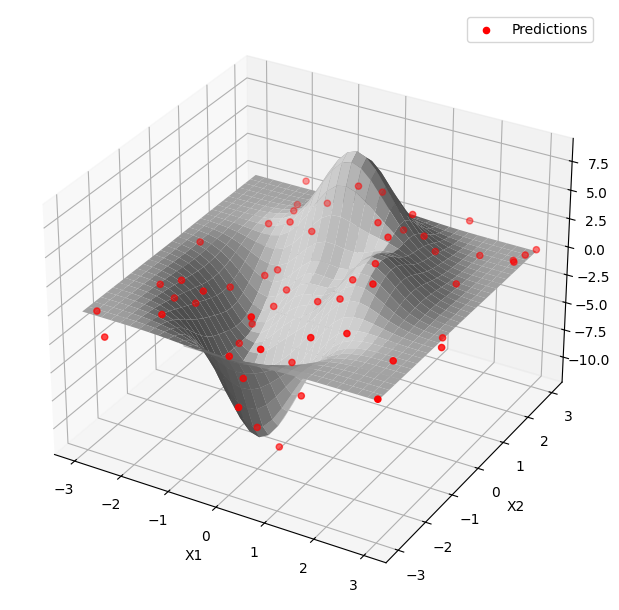

In [34]:
NOISE = 2.
TRAIN_RATIO = 0.3
N_SAMPLES = 200
BATCH_SIZE = int(TRAIN_RATIO*N_SAMPLES/2)

peaks = PeaksFunction()
train_loader, val_loader = peaks.prepare_dataset(n_samples=N_SAMPLES, test_size=(1-TRAIN_RATIO), batch_size=BATCH_SIZE, noise=NOISE)
peaks.plot_scatter()

### Entrenamiento
Observa lo que ocurre al entrenar ambos modelos durante 500 épocas y con un *learning rate* de 0.005.

Training loop: 100%|██████████| 500/500 [00:03<00:00, 125.48it/s]



Train loss final: 6.3431
Val loss final: 7.6271


Training loop: 100%|██████████| 500/500 [00:05<00:00, 93.44it/s] 



Train loss final: 0.1650
Val loss final: 5.2650


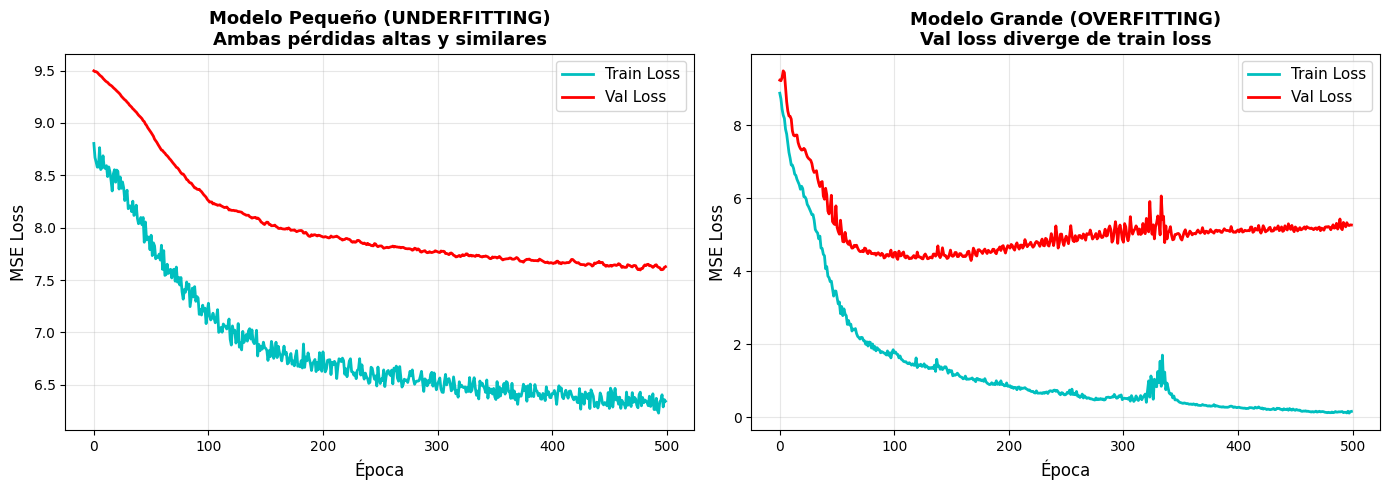

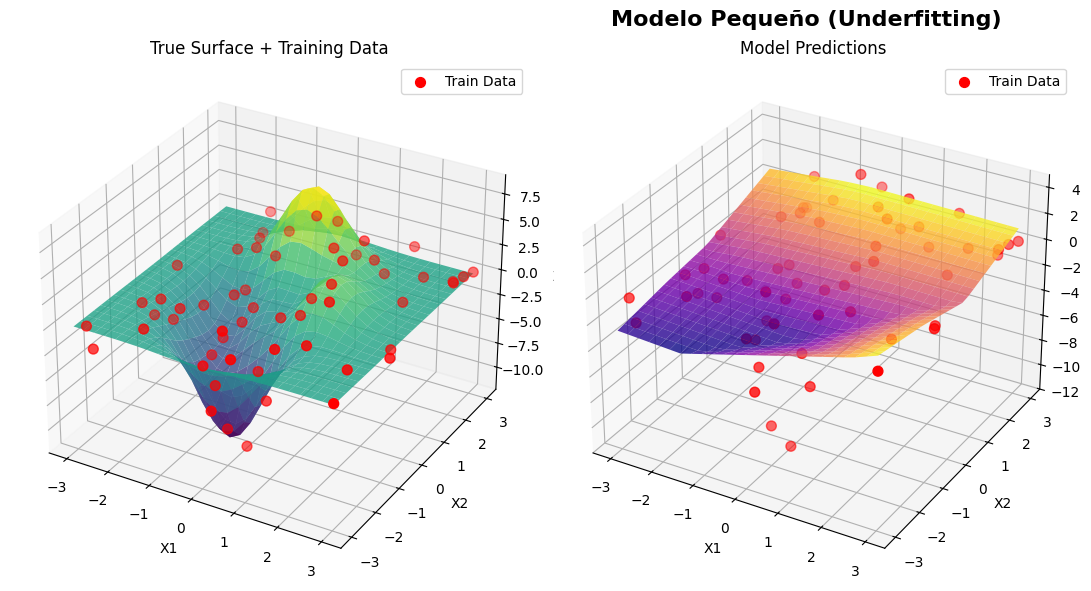

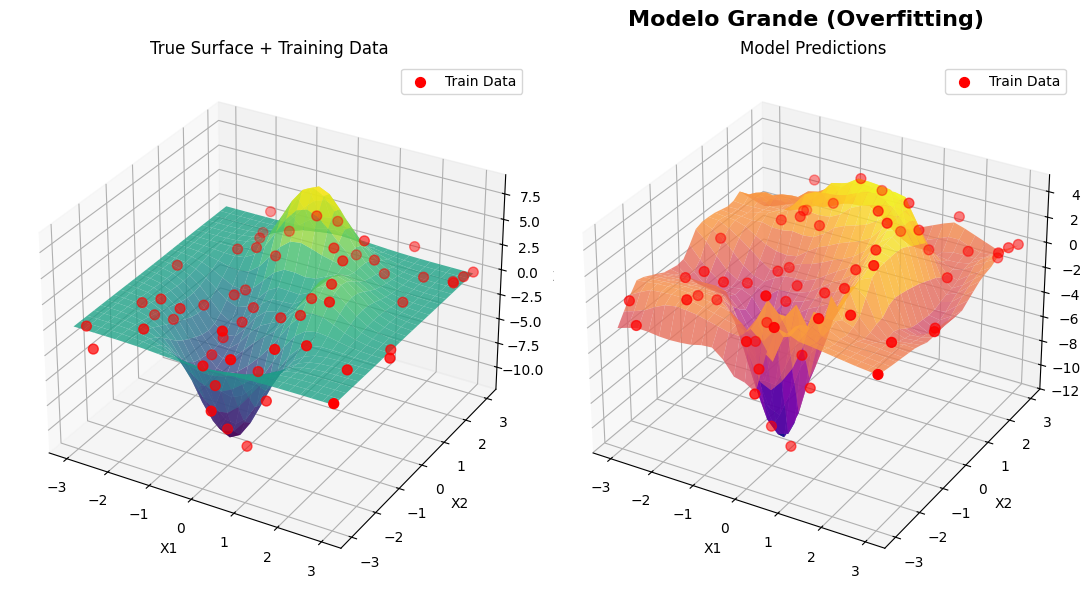

In [35]:
EPOCHS = 500
LR = 0.005

# Entrenar modelo pequeño (underfitting moderado)
input_size = train_loader.dataset.tensors[0].shape[1]
device = train_loader.dataset.tensors[0].device
small = SmallModel(input_size).to(device)
history_small = train_model(small, train_loader, val_loader, epochs=EPOCHS, lr=LR)

print(f"\nTrain loss final: {history_small['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_small['val_loss'][-1]:.4f}")

# Entrenar modelo grande (overfitting)
large = LargeModel(input_size).to(device)
history_large = train_model(large, train_loader, val_loader, epochs=EPOCHS, lr=LR)

print(f"\nTrain loss final: {history_large['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_large['val_loss'][-1]:.4f}")

# Representar curvas de aprendizaje
plot_learning_curve_comparison(history_small, history_large)

# Visualizar predicciones de ambos modelos
fig_small = peaks.plot_predictions_surface(small, device, n_points=25, title='Modelo Pequeño (Underfitting)')
fig_large = peaks.plot_predictions_surface(large, device, n_points=25, title='Modelo Grande (Overfitting)')

## **Estrategias para prevenir el overfitting**

### **1 - Early Stopping**

**Early Stopping** detiene automáticamente el entrenamiento cuando la validación loss deja de mejorar.

**Ventajas:**
- Simple de implementar
- Muy efectivo para prevenir overfitting
- Ahorra tiempo de entrenamiento

**Parámetros clave:**
- `patience`: Cuántas épocas esperar sin mejora antes de parar
- `min_delta`: Cambio mínimo para contar como "mejora"

📝 **Tarea**: adapta el método de entrenamiento para incluir early stopping de una forma sencilla. En la práctica, este método se aplica utilizando programación orientada a objetos. Para conocer más, consulta este [artículo](https://medium.com/biased-algorithms/a-practical-guide-to-implementing-early-stopping-in-pytorch-for-model-training-99a7cbd46e9d).

In [36]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.01, early_stopping=False, patience=20, min_delta=0.001):
    """
    Función para entrenar modelos.
    
    Parámetros:
        early_stopping: Si True, detiene cuando val_loss no mejora
        patience: Cuántas épocas esperar sin mejora
        min_delta: mínimo cambio en la función objetivo que se considera mejora
    """
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': []}

    # Inicializa las variables para monitorear el error en validación
    best_val_loss = float(1e15)
    patience_counter = 0

    for epoch in tqdm(range(epochs), desc="Training loop"):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fcn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        val_loss = 0
        model.eval()
        for X_batch, y_batch in val_loader:
            with torch.no_grad():
                y_pred_val = model(X_batch)
                loss = loss_fcn(y_pred_val, y_batch)

                val_loss += loss
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Early stopping
        if early_stopping:
            improvement = -1 * (val_loss.item() - best_val_loss)
            if improvement > min_delta:
                best_val_loss = val_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Interrupción del entrenamiento por early stopping (epoch: {epoch})")
                    break
            
    return history

Training loop:  44%|████▍     | 221/500 [00:02<00:03, 85.33it/s]


Interrupción del entrenamiento por early stopping (epoch: 221)

Train loss final: 0.8159
Val loss final: 4.5147


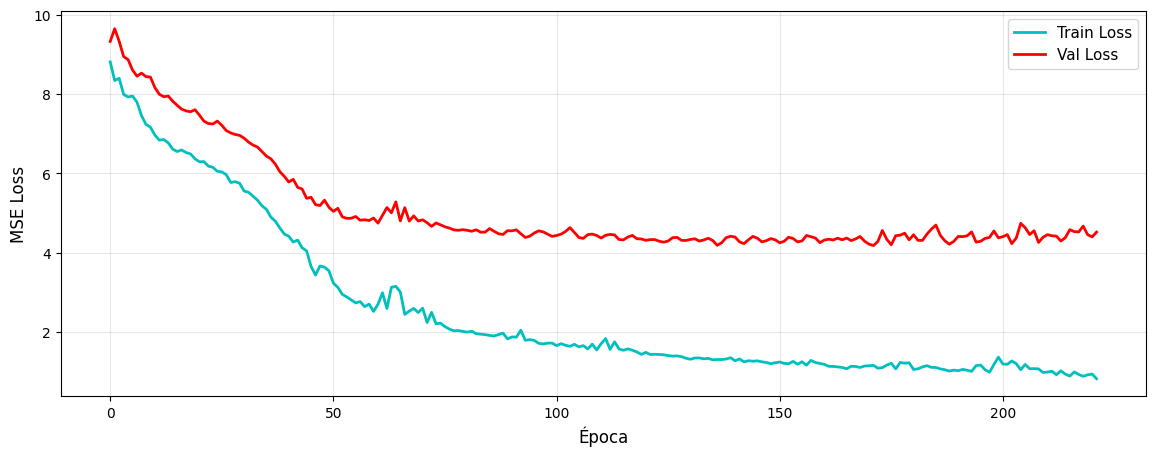

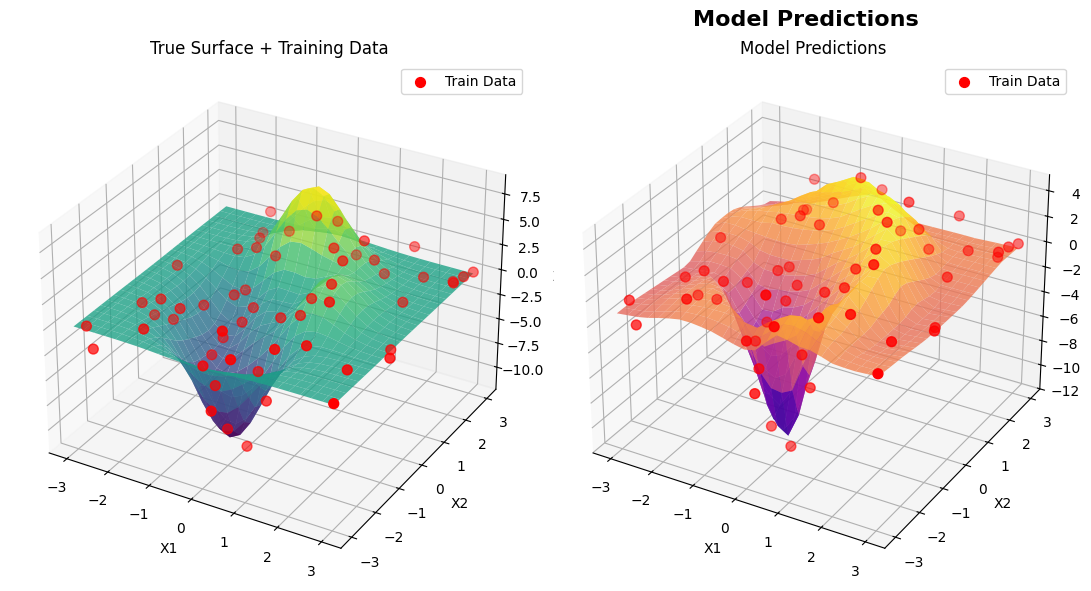

In [37]:
EPOCHS = 500
LR = 0.005
PATIENCE = 50
MIN_DELTA = 1e-4
EARLY_STOP = True

# Entrenar modelo grande (overfitting)
large_earlystop = LargeModel(input_size).to(device)
history_earlystop = train_model(large_earlystop, train_loader, val_loader, epochs=EPOCHS, lr=LR, early_stopping = EARLY_STOP, patience=PATIENCE, min_delta = MIN_DELTA)

print(f"\nTrain loss final: {history_earlystop['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_earlystop['val_loss'][-1]:.4f}")

plot_learning_curve(history_earlystop)
fig_earlystop = peaks.plot_predictions_surface(large_earlystop, device, n_points=25)

### **2 - Dropout**

**Dropout** desactiva aleatoriamente una fracción de neuronas durante el entrenamiento, siendo una de las técnicas de regularización de redes neuronales más eficaces y utilizadas. Por ejemplo, si la salida de una capa oculta fuera un vector `[0,2, 0,5, 1,3, 0,8, 1,1]`, después de aplicar el dropout, alguno de sus elementos tomarán el valor de 0 al azar `[0, 0,5, 1,3, 0, 1,1]`.

La fracción de las características que se anulan se conoce como *dropout rate* ($p$).

**Características:**
- Solo se aplica durante entrenamiento (`.train()`)
- Durante evaluación, todas las neuronas están activas (`.eval()`)
- Valores típicos: $0.2 \leq p \leq 0.5$

Para aplicarlo, se incluye como una "capa adicional" tipo [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) después de la función de activación.

📝 **Tarea**: basándote en el modelo `LargeModel`, realiza las modificaciones necesarias para añadir dropout en todas las capas ocultas.

In [38]:
class LargeModelDropout(nn.Module):
    """Modelo grande CON Dropout para prevenir overfitting"""
    def __init__(self, input_size, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

Training loop: 100%|██████████| 500/500 [00:07<00:00, 63.81it/s]



Train loss final: 2.4234
Val loss final: 5.0030


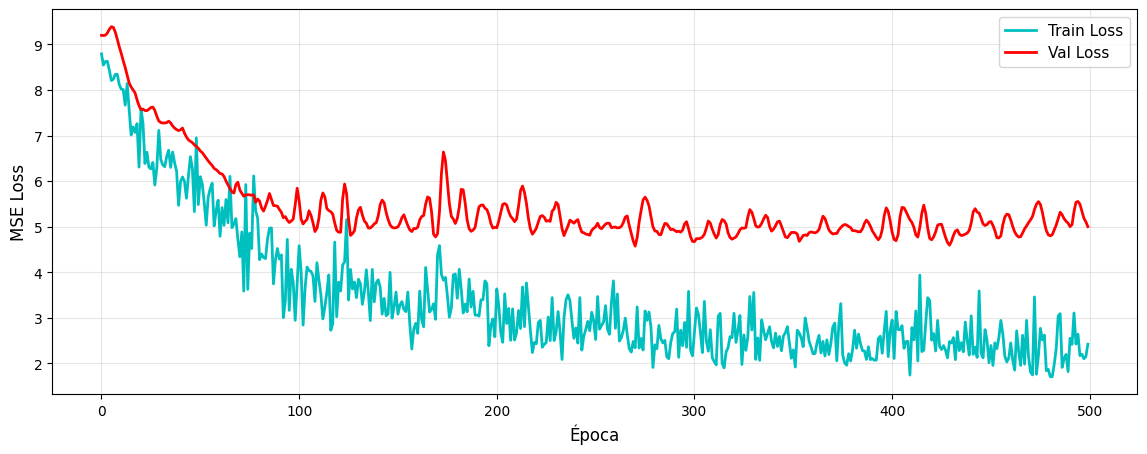

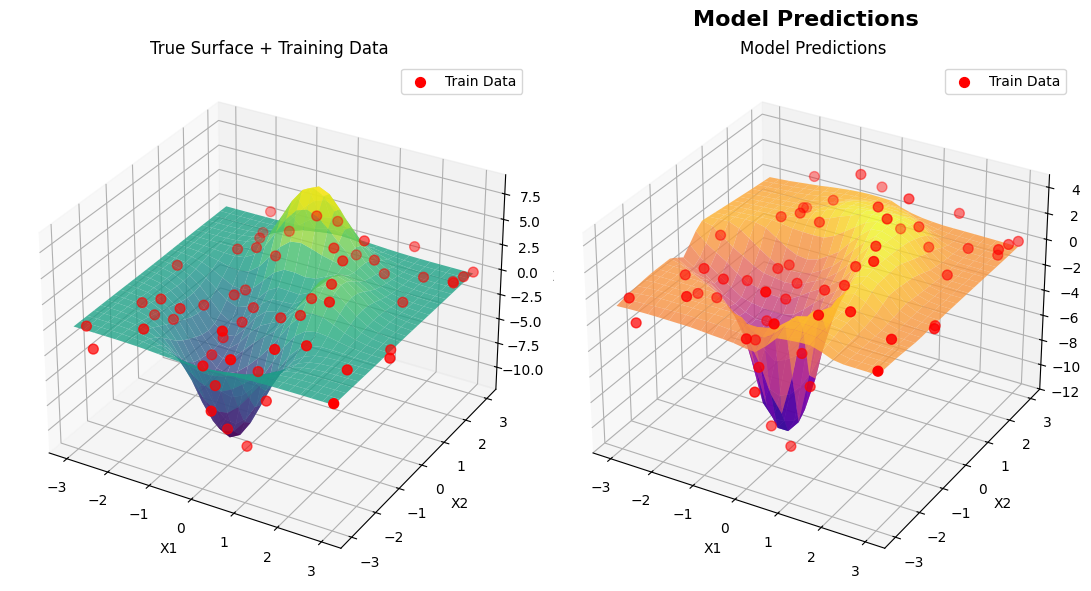

In [39]:
EPOCHS = 500
LR = 0.005
DROPOUT_RATE = 0.3
EARLY_STOP = False

# Entrenar modelo con dropout
large_dropout = LargeModelDropout(input_size, dropout_rate = DROPOUT_RATE).to(device)
history_dropout = train_model(large_dropout, train_loader, val_loader, epochs=EPOCHS, lr=LR, early_stopping = EARLY_STOP)

print(f"\nTrain loss final: {history_dropout['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_dropout['val_loss'][-1]:.4f}")

plot_learning_curve(history_dropout)
fig_dropout = peaks.plot_predictions_surface(large_dropout, device, n_points=25)

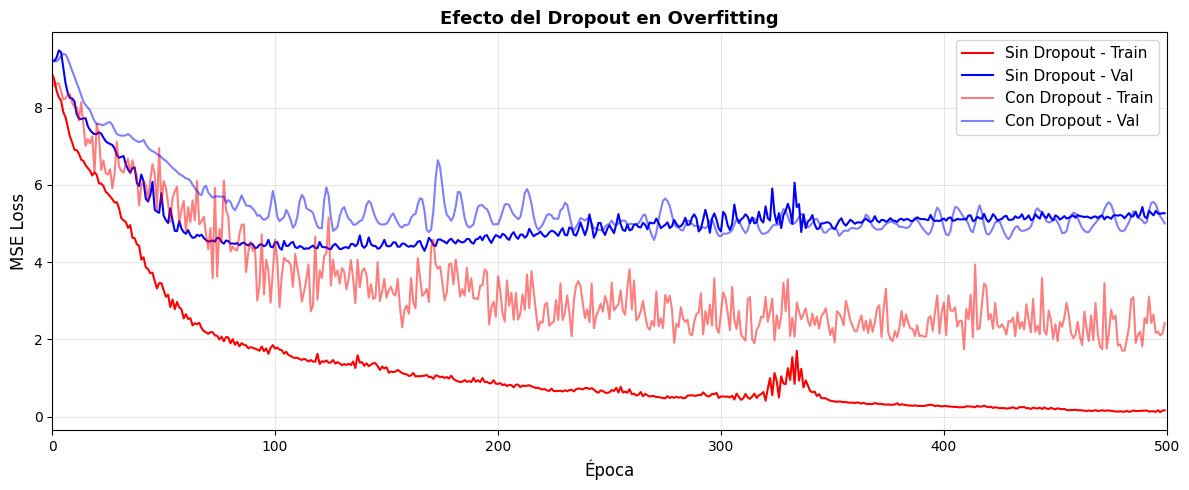

In [40]:
# Comparar: Sin Dropout vs Con Dropout
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(history_large['train_loss'], label='Sin Dropout - Train', color="red")
ax.plot(history_large['val_loss'], label='Sin Dropout - Val', color="blue")

ax.plot(history_dropout['train_loss'], label='Con Dropout - Train', color="red",  alpha = 0.5)
ax.plot(history_dropout['val_loss'], label='Con Dropout - Val', color="blue", alpha = 0.5)

ax.set_xlim(0,len(history_dropout["train_loss"]))
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Efecto del Dropout en Overfitting', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **3 - Regularización L1/L2**

Una forma común de mitigar el sobreajuste es forzando a que los pesos tomen valores pequeños. La **regularización** añade un término de penalización a la función de pérdida basado en el tamaño de los pesos. El parámetro $\lambda$ se denomina *weight decay*.

**L2 (Ridge) Regularization:**
$$\text{Loss}_{total} = \text{Loss}_{original} + \lambda \sum_i w_i^2$$

- Penaliza pesos grandes
- Favorece pesos pequeños pero no necesariamente cero
- Muy común en deep learning, ya que evita el fenómeno de [*vanishing gradients*](https://www.youtube.com/watch?v=8z3DFk4VxRo)

**L1 (Lasso) Regularization:**
$$\text{Loss}_{total} = \text{Loss}_{original} + \lambda \sum_i |w_i|$$

- Tiende a hacer algunos pesos exactamente cero
- Útil para selección de características

**En PyTorch:**
- Opción manual: calcular los términos L1 y L2 dentro del training loop y sumarlos al valor de la función de pérdidas
- Opción automática: la mayoría de los optimizadores incluyen la opción de especificar el valor de $\lambda$, aplicando internamente la regularización L2.

<center>
<pre><code class="language-python">
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=0.01)
</code></pre>
</center>

💡 **Nota:** para el algoritmo [Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.adam.Adam_class.html#adam), `weight_decay`>0 no es exactamente regularización L2. En ese caso, es preferible utilizar [AdamW](https://docs.pytorch.org/docs/stable/generated/torch.optim.adamw.AdamW_class.html).

📝 **Tarea:** completa el código incluyendo cómo calcular los términos L1 y L2. Después, compara con la opción ya implementada en Pytorch.

In [41]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.01, early_stopping=False, patience=20, min_delta=0.001, regularization=None, weight_decay = 0.001):
    """
    Función para entrenar modelos.
    
    Parámetros:
        early_stopping: Si True, detiene cuando val_loss no mejora
        patience: Cuántas épocas esperar sin mejora
        min_delta: mínimo cambio en la función objetivo que se considera mejora
    """
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': []}

    # Inicializa las variables para monitorear el error en validación
    best_val_loss = float(1e15)
    patience_counter = 0

    for epoch in tqdm(range(epochs), desc="Training loop"):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fcn(y_pred, y_batch)

            # Apply L2 regularization
            if regularization == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += weight_decay * l2_norm

            # Apply L1 regularization
            elif regularization == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += weight_decay * l1_norm
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)


        # Validation
        val_loss = 0
        model.eval()
        for X_batch, y_batch in val_loader:
            with torch.no_grad():
                y_pred_val = model(X_batch)
                loss = loss_fcn(y_pred_val, y_batch)

                val_loss += loss
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Early stopping
        if early_stopping:
            improvement = -1 * (val_loss.item() - best_val_loss)
            if improvement > min_delta:
                best_val_loss = val_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Interrupción del entrenamiento por early stopping (epoch: {epoch})")
                    break
            
    return history

Training loop: 100%|██████████| 500/500 [00:09<00:00, 51.57it/s]



Train loss final: 2.8047
Val loss final: 4.2077


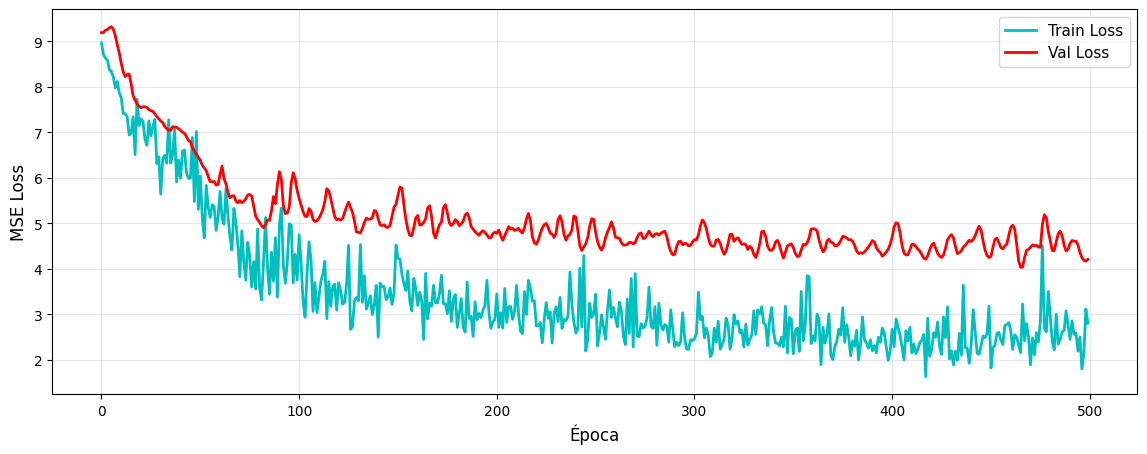

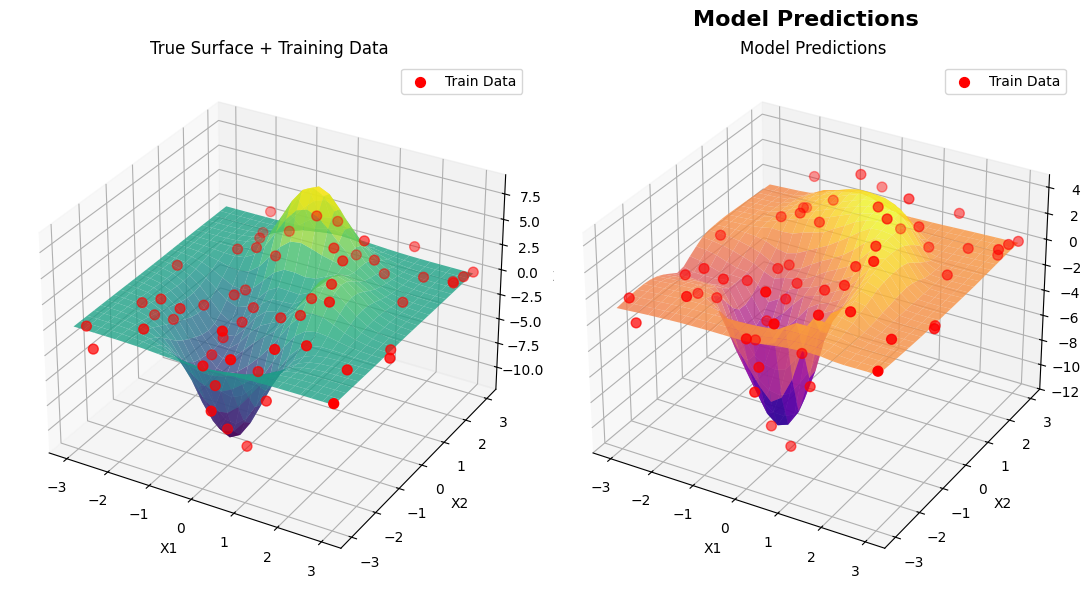

In [42]:
EPOCHS = 500
LR = 0.005
EARLY_STOP = False
REG = "L2"
LAMBDA = 0.001

# Entrenar modelo con dropout
large_reg = LargeModelDropout(input_size, dropout_rate = DROPOUT_RATE).to(device)
history_reg = train_model(large_reg, train_loader, val_loader, epochs=EPOCHS, lr=LR, early_stopping = EARLY_STOP, regularization=REG, weight_decay=LAMBDA)

print(f"\nTrain loss final: {history_reg['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_reg['val_loss'][-1]:.4f}")

plot_learning_curve(history_reg)
fig_dropout = peaks.plot_predictions_surface(large_reg, device, n_points=25)

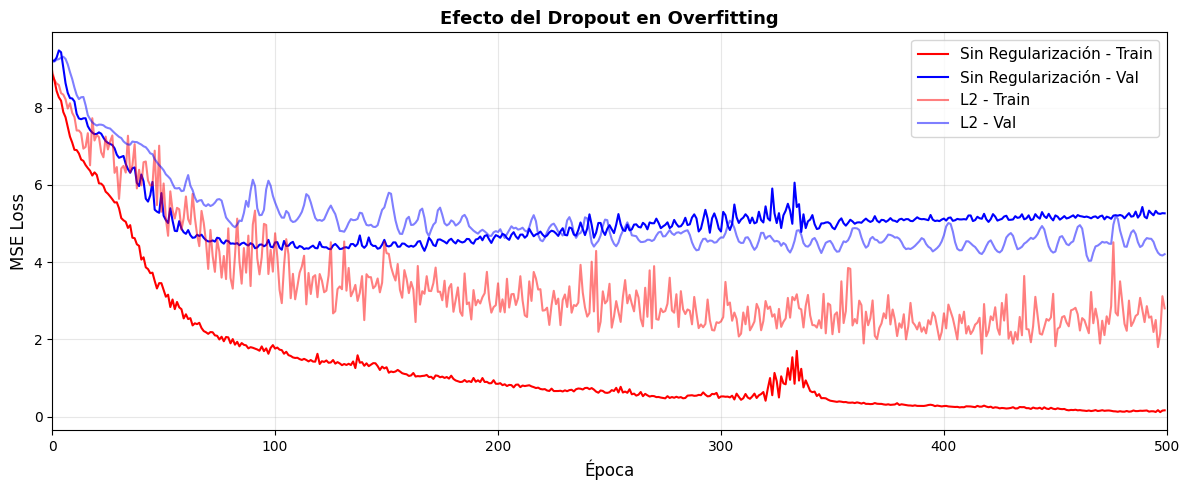

In [44]:
# Comparar: Sin Regularización vs Con Regularización
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(history_large['train_loss'], label='Sin Regularización - Train', color="red")
ax.plot(history_large['val_loss'], label='Sin Regularización - Val', color="blue")

ax.plot(history_reg['train_loss'], label=f'{REG} - Train', color="red",  alpha = 0.5)
ax.plot(history_reg['val_loss'], label=f'{REG} - Val', color="blue", alpha = 0.5)

ax.set_xlim(0,len(history_reg["train_loss"]))
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Efecto del Dropout en Overfitting', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()